## Using Bayesian Methods to Optimize Reaction Conditions
### Introduction 

In drug discovery, we frequently encounter situations where we need to modify a set of reaction conditions to optimize the yield. In an early discovery program, we may want to scale up a key intermediate to facilitate SAR exploration. In a later stage program, a process chemist may want to optimize a reaction for multi-kilo scale manufacture of the drug substance. A variety of strategies, ranging from intuition to design of experiments (DOE), are used to facilitate optimization. An alternative approach is to use Bayesian optimization, a technique that balances exploration and exploitation to identify optimal solutions. In this notebook, we will use [BayBE](https://github.com/emdgroup/baybe), an optimization library developed by scientists at Merck KGaA in Darmstadt, Germany.

In this example, we will consider a reaction described in the supporting material of a 2020 paper by [Shields](https://www.nature.com/articles/s41586-021-03213-y) and coworkers from UCLA. 

       
<center><img src="Shields_reaction.png" style="width: 50%; height: 50%"/></center>

We will optimize the 5 parameters shown in blue in the figure above.   Each of these parameters has a set of options available. 

<center><img src="Possible_conditions.png" style="width: 50%; height: 50%"/></center>

In total, there are 12 * 4 * 4 * 3 * 3 = 1728 possible combinations. We would like to identify the optimal conditions while running only a small number of experiments. Fortunately, Shields and coworkers investigated all 1728 combinations and provided a table with the conditions and corresponding yields. In this notebook, we will simulate a Bayesian optimization process. We will begin by identifying 10 initial reaction conditions. In practice, we would then run experiments to evaluate these conditions and record the corresponding reaction yields. However, in this case, we will look up the yields in a table. With the conditions and yields in hand, we can build a Bayesian model and use this model to select another 5 reaction conditions. We will then look up the yields for the 5 conditions and use this information to update the model. We will repeat this process through 5 rounds of optimization and examine the reaction yields for each optimization cycle. 

### Overview 


Bayesian optimization with BayBE proceeds through the following steps. After this brief overview, we will execute the code to run each of these steps.

1. **[Define the parameters](https://emdgroup.github.io/baybe/stable/userguide/parameters.html).** In this step, we define the reaction parameters to be optimized. Typically, we will optimize aspects such as the catalyst used in the reaction, the number of equivalents of catalyst, the reaction temperature, the reaction time, and the concentrations of reactants.
2. **[Define a search space](https://emdgroup.github.io/baybe/stable/userguide/searchspace.html).** The search space defines the combination of parameters to be searched. The search space is typically defined using the function **[Searchspace.from_product](https://emdgroup.github.io/baybe/stable/_autosummary/baybe.searchspace.core.SearchSpace.html#baybe.searchspace.core.SearchSpace.from_product)**, which creates a search space as the Cartesian product (all combinations) of the parameters. It's important not to confuse the Cartesian product of the parameters with the products of a reaction.
3. **[Define the target](https://emdgroup.github.io/baybe/stable/userguide/targets.html).** The target is the parameter we are optimizing. In the case of reaction optimization, this is typically the yield. BayBE can optimize a single parameter or multiple parameters at once. In this notebook, we'll focus on single parameter optimization, where we are only optimizing the yield. The targets are combined to generate an objective, which can either be maximized or minimized.
4. **[Define a recommender](https://emdgroup.github.io/baybe/stable/userguide/recommenders.html).** The recommender selects the next set of experiments to be performed. In this case, we'll use BayBE's **[TwoPhaseMetaRecommender](https://emdgroup.github.io/baybe/stable/_autosummary/baybe.recommenders.meta.sequential.TwoPhaseMetaRecommender.html#baybe.recommenders.meta.sequential.TwoPhaseMetaRecommender)**. This recommender behaves differently depending on whether it has experimental data. At the beginning of an optimization process, we typically don't have experimental data and want to find a diverse set of conditions to gather some initial data. If the **[TwoPhaseMetaRecommender](https://emdgroup.github.io/baybe/stable/_autosummary/baybe.recommenders.meta.sequential.TwoPhaseMetaRecommender.html#baybe.recommenders.meta.sequential.TwoPhaseMetaRecommender)** has no data available, it uses **[Farthest Point Sampling](https://emdgroup.github.io/baybe/stable/_autosummary/baybe.recommenders.pure.nonpredictive.sampling.FPSRecommender.html#baybe.recommenders.pure.nonpredictive.sampling.FPSRecommender)** to select a diverse set of initial conditions. If the recommender has data, it uses the **[BotorchRecommender](https://emdgroup.github.io/baybe/stable/_autosummary/baybe.recommenders.pure.bayesian.botorch.BotorchRecommender.html#baybe.recommenders.pure.bayesian.botorch.BotorchRecommender)**, a Bayesian optimizer that balances exploration and exploitation when selecting sets of reaction conditions.
5. **[Define a campaign](https://emdgroup.github.io/baybe/stable/userguide/campaigns.html).** In BayBE, the search space, objective, and recommender are combined into an object known as a **[Campaign](https://emdgroup.github.io/baybe/stable/userguide/campaigns.html)**. The Campaign has two important methods: **[recommend](https://emdgroup.github.io/baybe/stable/userguide/campaigns.html#getting-recommendations)**, which recommends the next set of experiments, and **[add_measurements](https://emdgroup.github.io/baybe/stable/userguide/campaigns.html#adding-measurements)**, which adds a set of experiments and updates the underlying Bayesian model. As mentioned above, if we call **recommend** before calling **add_measurements**, the **recommend** method uses farthest point sampling to select the next set of reaction conditions. If we call **recommend** after a call to **add_measurements**, the Bayesian model is used to select the next set of experiments.

The figure below provides a schematic overview of the components described above. 

<center><img src="baybe_architecture.png"/></center>

In [4]:
import pandas as pd
import seaborn as sns
from tqdm.auto import tqdm

from baybe.targets.numerical import NumericalTarget
from baybe.parameters import CategoricalParameter, NumericalDiscreteParameter, SubstanceParameter
from baybe.searchspace import SearchSpace
from baybe.objective import SingleTargetObjective
from baybe.recommenders import BotorchRecommender, FPSRecommender, TwoPhaseMetaRecommender
from baybe.campaign import Campaign
from baybe.constraints import DiscreteExcludeConstraint, ThresholdCondition, SubSelectionCondition, DiscreteCustomConstraint
from baybe.surrogates import GaussianProcessSurrogate

from baybe.insights.shap import SHAPInsight
from rdkit import Chem
import useful_rdkit_utils as uru

### 1. Define the parameters
In this section, we will define two different parameter types. A **[CategoricalParameter](https://emdgroup.github.io/baybe/stable/userguide/parameters.html#categoricalparameter)** has a text label, we will encode these labels using a technique known as **[1-hot encoding](https://www.geeksforgeeks.org/ml-one-hot-encoding/)**, which is widely used in machine learning.  A **[NumericalDiscreteParameter](https://emdgroup.github.io/baybe/stable/userguide/parameters.html#numericaldiscreteparameter)** encodes numeric parameters, which adopt a specific set of possible values.  For instance, below we set temperature (Temp_C) to one of three different values 90,105, or 120. As implemented below, each of the parameters is represented by a text buffer, which is translated to a dictionary. 

In [5]:
Base_SMILES = """O=C([O-])C.[K+]|KOAc
O=C([O-])C(C)(C)C.[K+]|KOPv
O=C([O-])C.[Cs+]|CsOAc
O=C([O-])C(C)(C)C.[Cs+]|CsOPv""".split("\n")
Base_SMILES = dict([tuple(reversed(x.split("|"))) for x in Base_SMILES])
Base_SMILES

{'KOAc': 'O=C([O-])C.[K+]',
 'KOPv': 'O=C([O-])C(C)(C)C.[K+]',
 'CsOAc': 'O=C([O-])C.[Cs+]',
 'CsOPv': 'O=C([O-])C(C)(C)C.[Cs+]'}

In [6]:
Ligand_SMILES = """CC(C)C1=CC(C(C)C)=C(C(C(C)C)=C1)C2=C(P(C3CCCCC3)C4CCCCC4)C(OC)=CC=C2OC|BrettPhos
CC(C)(C)P(C1=CC=CC=C1)C(C)(C)C|PPht-Bu2
CN(C)C1=CC=CC(N(C)C)=C1C2=CC=CC=C2P(C(C)(C)C)C3=CC=CC=C3|t-BuPh-CPhos
P(C1CCCCC1)(C2CCCCC2)C3CCCCC3|PCy3
P(C1=CC=CC=C1)(C2=CC=CC=C2)C3=CC=CC=C3|PPH3
CC(C1=C(C2=CC=CC=C2P(C3CCCCC3)C4CCCCC4)C(C(C)C)=CC(C(C)C)=C1)C|XPhos
P(C1=CC=CO1)(C2=CC=CO2)C3=CC=CO3|P(fur)3
CP(C1=CC=CC=C1)C2=CC=CC=C2|PPh2Me
CC(OC1=C(P(C2CCCCC2)C3CCCCC3)C(OC(C)C)=CC=C1)C|GlorPhos
FC(F)(F)C1=CC(P(C2=C(C3=C(C(C)C)C=C(C(C)C)C=C3C(C)C)C(OC)=CC=C2OC)C4=CC(C(F)(F)F)=CC(C(F)(F)F)=C4)=CC(C(F)(F)F)=C1|JackiePhos
C[C@]1(O2)O[C@](C[C@]2(C)P3C4=CC=CC=C4)(C)O[C@]3(C)C1|CgMe-PPh
CP(C)C1=CC=CC=C1|PPhMe2""".split("\n")
Ligand_SMILES = dict([tuple(reversed(x.split("|"))) for x in Ligand_SMILES])
Ligand_SMILES

{'BrettPhos': 'CC(C)C1=CC(C(C)C)=C(C(C(C)C)=C1)C2=C(P(C3CCCCC3)C4CCCCC4)C(OC)=CC=C2OC',
 'PPht-Bu2': 'CC(C)(C)P(C1=CC=CC=C1)C(C)(C)C',
 't-BuPh-CPhos': 'CN(C)C1=CC=CC(N(C)C)=C1C2=CC=CC=C2P(C(C)(C)C)C3=CC=CC=C3',
 'PCy3': 'P(C1CCCCC1)(C2CCCCC2)C3CCCCC3',
 'PPH3': 'P(C1=CC=CC=C1)(C2=CC=CC=C2)C3=CC=CC=C3',
 'XPhos': 'CC(C1=C(C2=CC=CC=C2P(C3CCCCC3)C4CCCCC4)C(C(C)C)=CC(C(C)C)=C1)C',
 'P(fur)3': 'P(C1=CC=CO1)(C2=CC=CO2)C3=CC=CO3',
 'PPh2Me': 'CP(C1=CC=CC=C1)C2=CC=CC=C2',
 'GlorPhos': 'CC(OC1=C(P(C2CCCCC2)C3CCCCC3)C(OC(C)C)=CC=C1)C',
 'JackiePhos': 'FC(F)(F)C1=CC(P(C2=C(C3=C(C(C)C)C=C(C(C)C)C=C3C(C)C)C(OC)=CC=C2OC)C4=CC(C(F)(F)F)=CC(C(F)(F)F)=C4)=CC(C(F)(F)F)=C1',
 'CgMe-PPh': 'C[C@]1(O2)O[C@](C[C@]2(C)P3C4=CC=CC=C4)(C)O[C@]3(C)C1',
 'PPhMe2': 'CP(C)C1=CC=CC=C1'}

We can use the RDKit to draw the structures of the ligands.  The function **rd_make_structures_pretty** from the [useful_rdkit_utils](https://github.com/PatWalters/useful_rdkit_utils) library adjusts a few settings to make the RDKit structure drawings look better. 

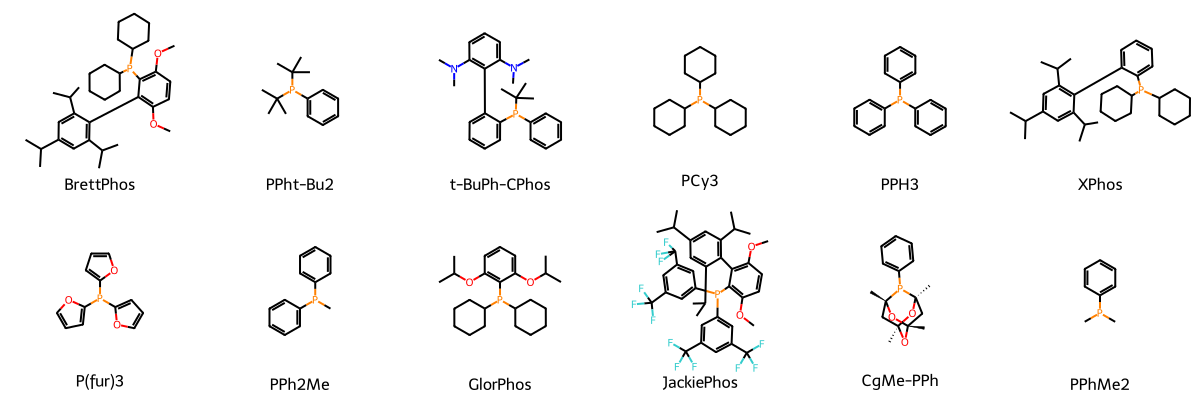

In [7]:
uru.rd_make_structures_pretty()
Chem.Draw.MolsToGridImage([Chem.MolFromSmiles(x) for x in Ligand_SMILES.values()],molsPerRow=6, 
                          legends=Ligand_SMILES.keys())

In the next few cells, we define the possible choices for sovent, concentration, and temperature.

In [8]:
Solvent_SMILES = """CC(N(C)C)=O|DMAc
CCCC#N|BuCN
CCCCOC(C)=O|BuOAc
CC1=CC=C(C)C=C1|p-Xylene""".split("\n")
Solvent_SMILES = dict([tuple(reversed(x.split("|"))) for x in Solvent_SMILES])
Solvent_SMILES

{'DMAc': 'CC(N(C)C)=O',
 'BuCN': 'CCCC#N',
 'BuOAc': 'CCCCOC(C)=O',
 'p-Xylene': 'CC1=CC=C(C)C=C1'}

The next two parameters are numeric so we'll convert the values to floating point numbers. 

In [9]:
Concentration = """0.057
0.1
0.153""".split("\n")
Concentration = [float(x) for x in Concentration]
Concentration

[0.057, 0.1, 0.153]

In [10]:
Temp_C = """90
105
120""".split("\n")
Temp_C = [float(x) for x in Temp_C]
Temp_C

[90.0, 105.0, 120.0]

After parsing the input data, we use the corresponding values to define parameters.  As mentioned above, the first three are of type **[CategoricalParameter](https://emdgroup.github.io/baybe/stable/userguide/parameters.html#categoricalparameter)** and the next two are of type **[NumericalDiscreteParameter](https://emdgroup.github.io/baybe/stable/userguide/parameters.html#numericaldiscreteparameter)**. 

In [11]:
ohe_base_param = CategoricalParameter(values=Base_SMILES.values(), name="Base_SMILES")
ohe_ligand_param = CategoricalParameter(values=Ligand_SMILES.values(),name="Ligand_SMILES")
ohe_solvent_param = CategoricalParameter(values=Solvent_SMILES.values(),name="Solvent_SMILES")
ohe_concentration_param = NumericalDiscreteParameter(values=Concentration,name="Concentration")
ohe_temp_param = NumericalDiscreteParameter(values=Temp_C,name="Temp_C")

After defining each of the individual parameters, the parameters are combined into a list. 

In [12]:
ohe_parameters = [ohe_base_param, ohe_ligand_param, ohe_solvent_param, ohe_concentration_param, ohe_temp_param]

### 2. Define the Searchspace
This parameter list is then used to generate the **[Searchspace](https://emdgroup.github.io/baybe/stable/userguide/searchspace.html)**. 

In [13]:
ohe_searchspace = SearchSpace.from_product(ohe_parameters)

Look at the size of the searchspace, which is 1728.  
4 Base * 12 Ligand * 4 Solvent * 3 Concentration * 3 Temperature = 1728 conditions

In [14]:
ohe_searchspace.estimate_product_space_size(ohe_parameters)

MemorySize(exp_rep_bytes=456912.0, exp_rep_shape=(1728, 5), comp_rep_bytes=304128, comp_rep_shape=(1728, 22))

### 3. Define the Target
In this case our **[Target](https://emdgroup.github.io/baybe/stable/userguide/targets.html)** is the yield.  We are only optimizing a single objective so we will use the BayBE **[SingleTargetOjective](https://emdgroup.github.io/baybe/stable/userguide/objectives.html#singletargetobjective)**. Note that we set **mode** to **MAX** indicating that we want to maximize the yield. 

In [15]:
ohe_target = NumericalTarget(name="yield", mode="MAX")
ohe_objective = SingleTargetObjective(ohe_target)

### 4. Define the Recommender
The [**Recommender**](https://emdgroup.github.io/baybe/stable/userguide/recommenders.html) selects the next set of experiments to try.  If there is no data available, the recommender uses **[farthest point sampling](https://emdgroup.github.io/baybe/stable/_autosummary/baybe.recommenders.pure.nonpredictive.sampling.FPSRecommender.html#baybe.recommenders.pure.nonpredictive.sampling.FPSRecommender)** to select a diverse set of conditions.  If data is available, the Bayesian **[BotorchRecommender](https://emdgroup.github.io/baybe/stable/_autosummary/baybe.recommenders.pure.bayesian.botorch.BotorchRecommender.html#baybe.recommenders.pure.bayesian.botorch.BotorchRecommender)** is used to balance exploration and exploitation and select the next set of reaction conditions. 

In [16]:
ohe_recommender = TwoPhaseMetaRecommender(
    initial_recommender=FPSRecommender(),  # farthest point sampling
    recommender=BotorchRecommender(),  # Bayesian model-based optimization
)

### 5. Define the Campaign
The Searchspace, Objective and Recommender are combined to produce a **[Campaign](https://emdgroup.github.io/baybe/stable/userguide/campaigns.html)**, which is used to suggest experiments and take in experimental data.  The Campaign has two primary methods: **[recommend](https://emdgroup.github.io/baybe/stable/userguide/campaigns.html#getting-recommendations)**, which provides suggested reaction conditions, and **[add_measurements](https://emdgroup.github.io/baybe/stable/userguide/campaigns.html#adding-measurements)**, which takes in experimental data and updates the Bayesian model. 

In [17]:
ohe_campaign = Campaign(ohe_searchspace, ohe_objective, ohe_recommender)

### 6. Get an Initial Set of Recommendations
Now that the Campaign is defined, we can ask it for recommendations. So far, we haven't done any experiments. As such, the Campaign will use farthest point sampling to select a diverse set of initial conditions.

In [18]:
ohe_rec_1 = ohe_campaign.recommend(10)
ohe_rec_1

,Base_SMILES,Ligand_SMILES,Solvent_SMILES,Concentration,Temp_C
0,O=C([O-])C(C)(C)C.[Cs+],CC(C)(C)P(C1=CC=CC=C1)C(C)(C)C,CC(N(C)C)=O,0.057,90.0
485,O=C([O-])C(C)(C)C.[K+],CC(C)C1=CC(C(C)C)=C(C(C(C)C)=C1)C2=C(P(C3CCCCC...,CC1=CC=C(C)C=C1,0.153,120.0
960,O=C([O-])C.[Cs+],CC(C1=C(C2=CC=CC=C2P(C3CCCCC3)C4CCCCC4)C(C(C)C...,CCCC#N,0.153,90.0
1469,O=C([O-])C.[K+],CN(C)C1=CC=CC(N(C)C)=C1C2=CC=CC=C2P(C(C)(C)C)C...,CCCCOC(C)=O,0.057,120.0
1555,O=C([O-])C.[K+],C[C@]1(O2)O[C@](C[C@]2(C)P3C4=CC=CC=C4)(C)O[C@...,CC(N(C)C)=O,0.153,105.0
1090,O=C([O-])C.[Cs+],CP(C1=CC=CC=C1)C2=CC=CC=C2,CC1=CC=C(C)C=C1,0.057,105.0
559,O=C([O-])C(C)(C)C.[K+],CC(OC1=C(P(C2CCCCC2)C3CCCCC3)C(OC(C)C)=CC=C1)C,CCCC#N,0.057,105.0
322,O=C([O-])C(C)(C)C.[Cs+],FC(F)(F)C1=CC(P(C2=C(C3=C(C(C)C)C=C(C(C)C)C=C3...,CCCCOC(C)=O,0.153,105.0
1632,O=C([O-])C.[K+],P(C1=CC=CC=C1)(C2=CC=CC=C2)C3=CC=CC=C3,CC1=CC=C(C)C=C1,0.100,90.0
822,O=C([O-])C(C)(C)C.[K+],P(C1=CC=CO1)(C2=CC=CO2)C3=CC=CO3,CCCCOC(C)=O,0.100,90.0


### 7. Perform Experiments
At this point we would typically perform a set of experiments using the 10 recommendations provided by the Campaign.  However, in the interest of efficiency, we will look up the reaction yeields in a database.  To do this, we will define a Python class that reads a file with data from [Shields, et al](https://www.nature.com/articles/s41586-021-03213-yhttps://www.nature.com/articles/s41586-021-03213-y) and looks up the reaction yield.  

In [19]:
class ReactionLookup:
    def __init__(self,infile_name):
        self.df = pd.read_csv(infile_name)

    def lookup_yields_from_SMILES(self, query):
        query_cols = ["Base_SMILES","Ligand_SMILES","Solvent_SMILES","Concentration","Temp_C"]
        return self.df.merge(query, on=query_cols)[query_cols + ["yield"]]

    def lookup_yields_from_Name(self, query):
        query_cols = ["Base_Name","Ligand_Name","Solvent_Name","Concentration","Temp_C"]
        return self.df.merge(query, on=query_cols)[query_cols + ["yield"]]

reaction_lookup = ReactionLookup("direct_arylation.csv")

Look up the yields for our first 10 conditions. 

In [17]:
ohe_rec_1_results = reaction_lookup.lookup_yields_from_SMILES(ohe_rec_1)
ohe_rec_1_results

,Base_SMILES,Ligand_SMILES,Solvent_SMILES,Concentration,Temp_C,yield
0,O=C([O-])C.[K+],P(C1=CC=CC=C1)(C2=CC=CC=C2)C3=CC=CC=C3,CC1=CC=C(C)C=C1,0.100,90,0.55
1,O=C([O-])C(C)(C)C.[Cs+],CC(C)(C)P(C1=CC=CC=C1)C(C)(C)C,CC(N(C)C)=O,0.057,90,0.00
2,O=C([O-])C.[K+],CN(C)C1=CC=CC(N(C)C)=C1C2=CC=CC=C2P(C(C)(C)C)C...,CCCCOC(C)=O,0.057,120,6.22
3,O=C([O-])C.[Cs+],CC(C1=C(C2=CC=CC=C2P(C3CCCCC3)C4CCCCC4)C(C(C)C...,CCCC#N,0.153,90,0.00
4,O=C([O-])C(C)(C)C.[K+],CC(C)C1=CC(C(C)C)=C(C(C(C)C)=C1)C2=C(P(C3CCCCC...,CC1=CC=C(C)C=C1,0.153,120,49.57
5,O=C([O-])C(C)(C)C.[K+],P(C1=CC=CO1)(C2=CC=CO2)C3=CC=CO3,CCCCOC(C)=O,0.100,90,25.00
6,O=C([O-])C(C)(C)C.[K+],CC(OC1=C(P(C2CCCCC2)C3CCCCC3)C(OC(C)C)=CC=C1)C,CCCC#N,0.057,105,49.19
7,O=C([O-])C.[Cs+],CP(C1=CC=CC=C1)C2=CC=CC=C2,CC1=CC=C(C)C=C1,0.057,105,0.00
8,O=C([O-])C.[K+],C[C@]1(O2)O[C@](C[C@]2(C)P3C4=CC=CC=C4)(C)O[C@...,CC(N(C)C)=O,0.153,105,87.00
9,O=C([O-])C(C)(C)C.[Cs+],FC(F)(F)C1=CC(P(C2=C(C3=C(C(C)C)C=C(C(C)C)C=C3...,CCCCOC(C)=O,0.153,105,3.13


Now that we've performed experiments, we need to add the data from the experiments to the Campaign.  We do this with the **add_measurements** method. 

In [18]:
ohe_campaign.add_measurements(ohe_rec_1_results)

Now let's simulate what we would do in practice. 
- Ask the Campaign for another set of 5 recommendations.  Now that we've added measurements, the Campaign uses the underlying Bayesian model to select the next set of reaction conditions.
- Next we will look up the yield for that set of conditions and use the yield data to update the Bayesian model.

We'll repeat this process 5 times and examine the distribution of yields at each iteration. 

In [20]:
for i in tqdm(range(0,5)):
    rec = ohe_campaign.recommend(5)
    rec_results = reaction_lookup.lookup_yields_from_SMILES(rec)
    ohe_campaign.add_measurements(rec_results)

  0%|          | 0/5 [00:00<?, ?it/s]

Next, let's compare the yield values over the six optimization cycles. We can ask the Campaign to provide a table with the measurements.  Note that the dataframe returned has a column **BatchNr** indicating the optimization cycle. 

In [21]:
ohe_measurement_df = ohe_campaign.measurements
ohe_measurement_df

,Base_SMILES,Ligand_SMILES,Solvent_SMILES,Concentration,Temp_C,yield,BatchNr,FitNr
0,O=C([O-])C.[Cs+],CC(C)(C)P(C1=CC=CC=C1)C(C)(C)C,CC(N(C)C)=O,0.057,90,0.00,1,1.0
1,O=C([O-])C(C)(C)C.[K+],CN(C)C1=CC=CC(N(C)C)=C1C2=CC=CC=C2P(C(C)(C)C)C...,CCCCOC(C)=O,0.057,120,3.88,1,1.0
2,O=C([O-])C(C)(C)C.[Cs+],CC(C1=C(C2=CC=CC=C2P(C3CCCCC3)C4CCCCC4)C(C(C)C...,CCCC#N,0.153,90,75.40,1,1.0
3,O=C([O-])C.[K+],CC(C)C1=CC(C(C)C)=C(C(C(C)C)=C1)C2=C(P(C3CCCCC...,CC1=CC=C(C)C=C1,0.153,120,18.89,1,1.0
4,O=C([O-])C(C)(C)C.[K+],C[C@]1(O2)O[C@](C[C@]2(C)P3C4=CC=CC=C4)(C)O[C@...,CC(N(C)C)=O,0.153,105,98.49,1,1.0
5,O=C([O-])C(C)(C)C.[Cs+],CC(C1=C(C2=CC=CC=C2P(C3CCCCC3)C4CCCCC4)C(C(C)C...,CCCC#N,0.100,105,68.53,2,2.0
6,O=C([O-])C(C)(C)C.[K+],C[C@]1(O2)O[C@](C[C@]2(C)P3C4=CC=CC=C4)(C)O[C@...,CC(N(C)C)=O,0.100,105,89.76,2,2.0
7,O=C([O-])C(C)(C)C.[K+],C[C@]1(O2)O[C@](C[C@]2(C)P3C4=CC=CC=C4)(C)O[C@...,CC(N(C)C)=O,0.153,90,61.09,2,2.0
8,O=C([O-])C(C)(C)C.[K+],C[C@]1(O2)O[C@](C[C@]2(C)P3C4=CC=CC=C4)(C)O[C@...,CCCC#N,0.153,105,69.20,2,2.0
9,O=C([O-])C(C)(C)C.[K+],C[C@]1(O2)O[C@](C[C@]2(C)P3C4=CC=CC=C4)(C)O[C@...,CC(N(C)C)=O,0.153,120,99.81,2,2.0


To get an idea of how the reaction yields improve over multiple cycles, we can plot **yield** as a function of **batch number**.  

<Axes: xlabel='BatchNr', ylabel='yield'>

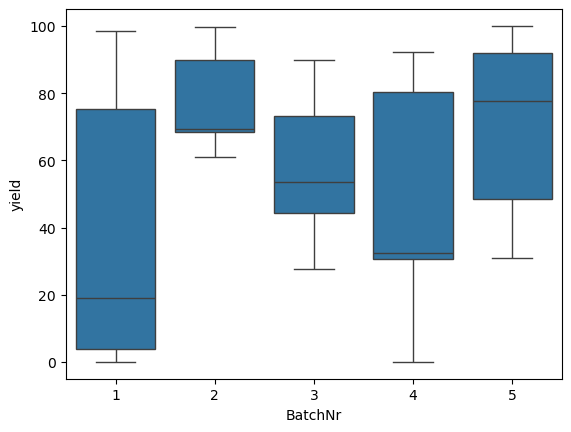

In [22]:
sns.boxplot(x="BatchNr",y="yield",data=ohe_measurement_df)

### Optimizing With Substance Parameters 
In the sections above we used One-Hot Encoding to describe our reactants and catalysts. Each of the parameters was simply a label, the optimization process didn't include any notions of chemistry.  BayBE provides another parameter type called a [SubstanceParameter](https://emdgroup.github.io/baybe/stable/userguide/parameters.html#substanceparameter), where chemical entities are described by a set of molecular descriptors.   These descriptors enable the model to attribute similar behaviors to similar chemicals.  In the code block below, we define the base, ligand, and solvent with SubstanceParameters.  Note that this definition is similar to the way we defined the CategoricalParameters above, with two notable exceptions.  
- First we define an encoding, which uses the **[Mordred](https://jcheminf.biomedcentral.com/articles/10.1186/s13321-018-0258-y)** descriptor calculator.
- Second, we specify **decorrelate=0.7**, which removes correlated descriptors and makes the calculations more efficient.
  
Note that the concentration and temperature parameters are defined as above. 

In [28]:
substance_base_param = SubstanceParameter(data=Base_SMILES, name="Base_Name", encoding="MORDRED", decorrelate=0.7)
substance_ligand_param = SubstanceParameter(data=Ligand_SMILES, name="Ligand_Name", encoding="MORDRED", decorrelate=0.7)
substance_solvent_param = SubstanceParameter(data=Solvent_SMILES, name="Solvent_Name",encoding="MORDRED",decorrelate=0.7)
concentration_param = NumericalDiscreteParameter(values=Concentration,name="Concentration")
temp_param = NumericalDiscreteParameter(values=Temp_C,name="Temp_C")
substance_params = [substance_base_param, substance_ligand_param, substance_solvent_param, concentration_param, temp_param]

The Searchspace, Target, and Recommender are defined as above. 

In [29]:
substance_searchspace = SearchSpace.from_product(substance_params)

In [30]:
substance_target = NumericalTarget(name="yield", mode="MAX")
substance_objective = SingleTargetObjective(substance_target)

In [31]:
substance_recommender = TwoPhaseMetaRecommender(
    initial_recommender=FPSRecommender(),  # farthest point sampling
    recommender=BotorchRecommender(),  # Bayesian model-based optimization
)

Combine the Searchspace, Objective, and Recommender to generate a Campaign. 

In [32]:
substance_campaign = Campaign(substance_searchspace, substance_objective, substance_recommender)

Get the initial recommendation using farthest point sampling. 

In [33]:
substance_rec_1 = substance_campaign.recommend(10)

In [34]:
substance_rec_1

,Base_Name,Ligand_Name,Solvent_Name,Concentration,Temp_C
135,CsOAc,JackiePhos,p-Xylene,0.057,90.0
1493,KOPv,PCy3,BuOAc,0.153,120.0
594,CsOPv,P(fur)3,DMAc,0.057,90.0
288,CsOAc,PPhMe2,BuCN,0.057,90.0
935,KOAc,CgMe-PPh,p-Xylene,0.153,120.0
1703,KOPv,t-BuPh-CPhos,BuOAc,0.057,120.0
783,CsOPv,PPht-Bu2,p-Xylene,0.057,90.0
24,CsOAc,BrettPhos,DMAc,0.153,90.0
1112,KOAc,PPH3,p-Xylene,0.100,120.0
1656,KOPv,XPhos,BuCN,0.057,90.0


Look up the yields for the initial 10 recommendations. 

In [35]:
substance_rec_1_results = reaction_lookup.lookup_yields_from_Name(substance_rec_1)

In [36]:
substance_rec_1_results

,Base_Name,Ligand_Name,Solvent_Name,Concentration,Temp_C,yield
0,KOAc,PPH3,p-Xylene,0.100,120,5.94
1,KOPv,XPhos,BuCN,0.057,90,30.83
2,CsOPv,PPht-Bu2,p-Xylene,0.057,90,0.00
3,KOPv,t-BuPh-CPhos,BuOAc,0.057,120,3.88
4,CsOAc,BrettPhos,DMAc,0.153,90,6.26
5,KOPv,PCy3,BuOAc,0.153,120,0.00
6,CsOPv,P(fur)3,DMAc,0.057,90,21.65
7,CsOAc,PPhMe2,BuCN,0.057,90,0.00
8,CsOAc,JackiePhos,p-Xylene,0.057,90,5.48
9,KOAc,CgMe-PPh,p-Xylene,0.153,120,60.29


In [37]:
substance_campaign.add_measurements(substance_rec_1_results)

Perform an additional 5 rounds of optimization, looking up experimental values for the reaction yields.

In [38]:
for i in tqdm(range(0,5)):
    substance_rec = substance_campaign.recommend(5)
    substance_rec_results = reaction_lookup.lookup_yields_from_Name(substance_rec)
    substance_campaign.add_measurements(substance_rec_results)

  0%|          | 0/5 [00:00<?, ?it/s]

In [39]:
substance_measurement_df = substance_campaign.measurements

To get an idea of how the reaction yields improve over multiple cycles, we can plot **yield** as a function of **batch number**.  

<Axes: xlabel='BatchNr', ylabel='yield'>

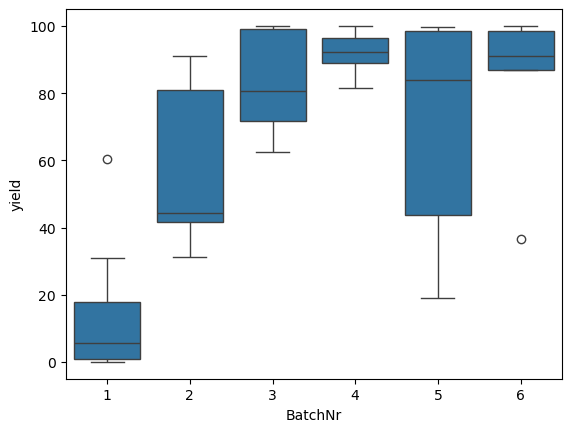

In [40]:
sns.boxplot(x="BatchNr",y="yield",data=substance_measurement_df)

### Assessing Feature Importance with BayBE Insights
BayBE also has the ability to [assess the importance of features](https://emdgroup.github.io/baybe/stable/userguide/insights.html) to the model.  This capability uses the [SHAP](https://shap.readthedocs.io/en/latest/) library for interpreting machine learning models. A larger SHAP value indicates that a feature has a larger impact on the model predictions.

In [35]:
insight = SHAPInsight.from_campaign(substance_campaign)

  0%|          | 0/35 [00:00<?, ?it/s]

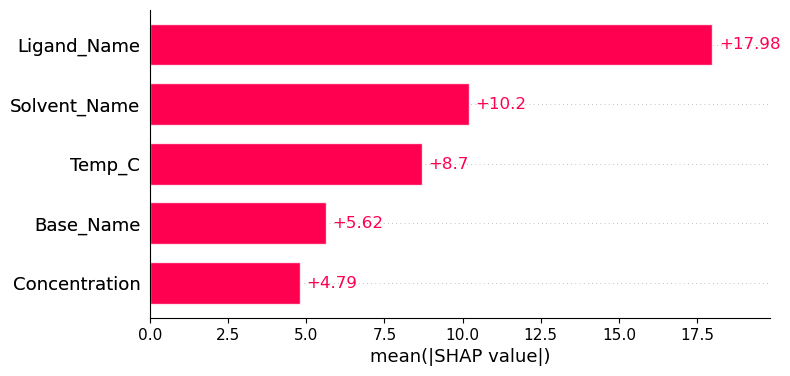

In [36]:
insight.plot("bar")

BayBE also supports a beeswarm plot where each point represents a set of reaction conditions.  Colors are used to represent the values of numeric parameters.  In the plot below, we see that we have higher SHAP values for higher temperatures and concentrations. 

  0%|          | 0/35 [00:00<?, ?it/s]

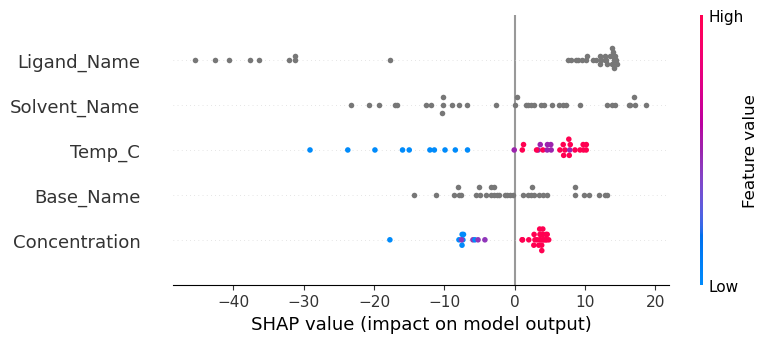

In [37]:
insight.plot("beeswarm")

We can also pass a dataset as the second argument to **[insight.plot](https://emdgroup.github.io/baybe/stable/userguide/insights.html#plots)** and examine a single interation.  In the plot below, we only look at BatchNr == 6. 

  0%|          | 0/5 [00:00<?, ?it/s]

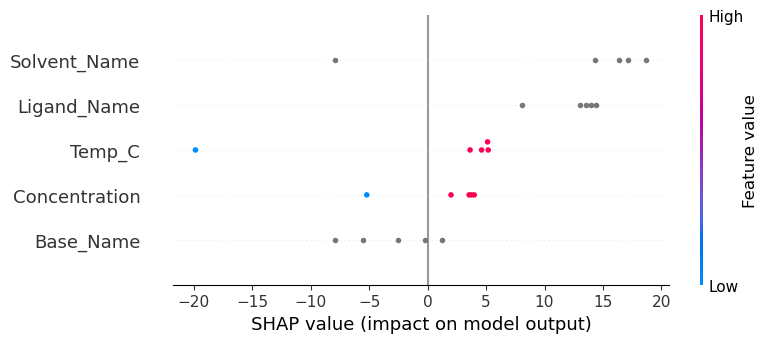

In [38]:
cols = ["Ligand_Name","Solvent_Name","Temp_C","Base_Name","Concentration"]
insight.plot("beeswarm",substance_measurement_df.query("BatchNr == 6")[cols])